### Common Test I. Multi-Class Classification (ResNet50 Transfer Learning)

#### **Name**:potla naga sai bharath 
#### **Gmail**:[saibharathpotla29@gmail.com](mailto:saibharathpotla29@gmail.com)

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset Description:** The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

*Trained model weigths for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1DGug4hP0UZBG2zAVWiO5lAgrlnf95l_Q?usp=drive_link)*


**Strategy**:
- Our methodology begins with the utilization of the pretrained ResNet50 architecture, from which the classification head is removed, followed by the flattening of the architecture.

- Subsequently, the integration of batch normalization and dropout techniques is undertaken to enhance the model's generalization capabilities, albeit with a potential trade-off in early convergence.

- Lastly, a dense layer with 3 outputs is introduced, coupled with the application of softmax activation, to facilitate the generation of probabilities corresponding to the 3 classes.






In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras import optimizers, metrics
from keras import layers, models, applications
from keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)

2.10.0


In [6]:
data_directory_traning ='/kaggle/working/dataset/train'
data_directory_validation='/kaggle/working/dataset/val'

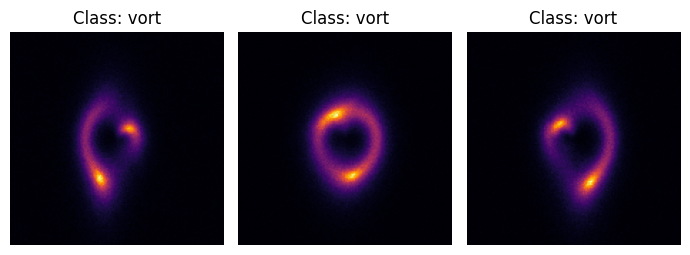

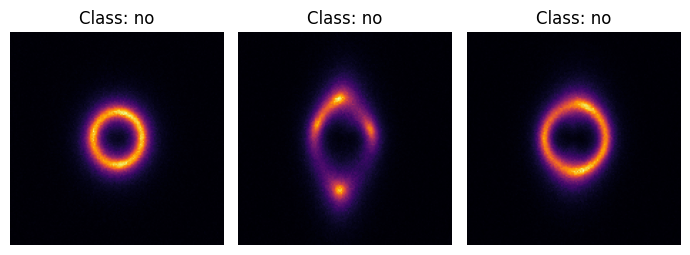

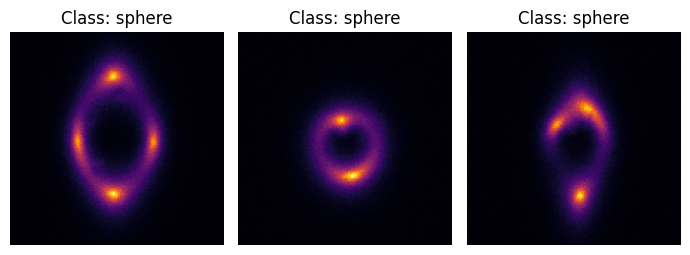

In [7]:
#Function to load and plot random images#####
def plot_random_images(data_dir, num_samples=3, num_cols=3):
    classes = os.listdir(data_dir)

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            images = [f for f in os.listdir(cls_path) if f.endswith('.npy')]

            if images:
                # Randomly select num_samples from the images
                random_images = random.sample(images, min(num_samples, len(images)))

                # Set up subplots
                fig, axes = plt.subplots(1, 3, figsize=(7,7))

                for i, img_filename in enumerate(random_images):
                    img_path = os.path.join(cls_path, img_filename)

                    # Load the image from .npy file (assuming it contains a NumPy array)
                    image = np.load(img_path)

                    # Assuming the image is in grayscale; modify if it's in color
                    ax = axes[i]
                    ax.imshow(image.T,cmap='inferno')
                    ax.set_title(f"Class: {cls}")
                    ax.axis('off')

                plt.tight_layout()
                plt.show()

# Plot 3 random images from the dataset using a 1x3 grid of subplots
plot_random_images(data_directory_traning, num_samples=3, num_cols=3)

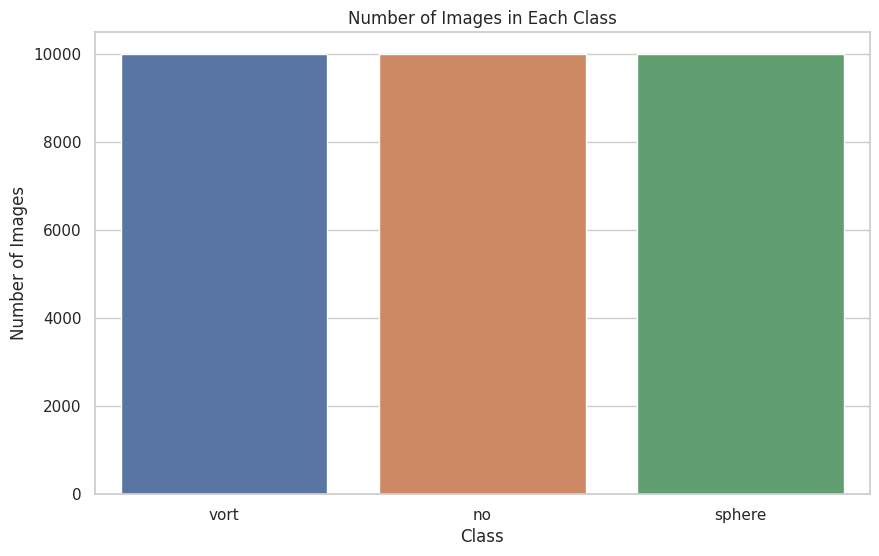

In [8]:
##########checking if the give dataset is blanced or imblanced dataset##############
import seaborn as sns
def count_images_per_class(data_dir):
    classes = os.listdir(data_dir)
    class_counts = []

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            images = [f for f in os.listdir(cls_path) if f.endswith('.npy')]
            num_images = len(images)
            class_counts.append((cls, num_images))

    return class_counts

# Get the total number of images in each class
class_counts = count_images_per_class(data_directory_traning)

# Plot the countplot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=[cls[0] for cls in class_counts], y=[cls[1] for cls in class_counts])
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [9]:
"""""
converting .npy images into jpg formate such that the images now have three channels and they can be easily used with ResNet50'
"""""
def convert_npy_to_jpeg(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    classes = ['no', 'sphere', 'vort']
    
    for c in classes:
        class_dir = os.path.join(input_dir, c)
        output_class_dir = os.path.join(output_dir, c)
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)
        for file in os.listdir(class_dir):
            if file.endswith('.npy'):
                npy_file = os.path.join(class_dir, file)
                img = np.load(npy_file)
                img = img.squeeze()
                img = np.uint8(img * 255)
                img = Image.fromarray(img)
                img.save(os.path.join(output_class_dir, os.path.splitext(file)[0] + '.jpeg'))

In [10]:
convert_npy_to_jpeg('/kaggle/working/dataset/train','/kaggle/working/dataset/traing_images')
convert_npy_to_jpeg('/kaggle/working/dataset/val','/kaggle/working/dataset/validation_images')

In [11]:
train_dir = '/kaggle/working/dataset/traing_images'
val_dir = '/kaggle/working/dataset/validation_images'

train_datagen = ImageDataGenerator(
    rescale=1./255,
  rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
   train_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical'
)

Found 30000 images belonging to 3 classes.
Found 7500 images belonging to 3 classes.


In [12]:
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Activation,BatchNormalization,Dropout
transfer_base = ResNet50( weights='imagenet',
          include_top=False,
          input_shape=(150, 150, 3))
model=Sequential()
model.add(transfer_base)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization (Batch  (None, 51200)             204800    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 128)               51

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 4.4 MB/s eta 0:00:0000:0100:01m


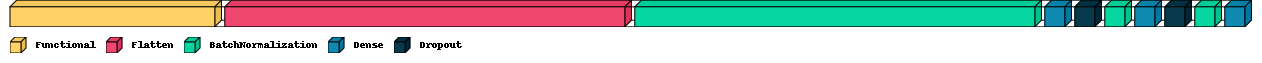

In [13]:
###visualization of the cnn cnn architecture###
#!pip install visualkeras(for install visualkeas please uncomment )
import visualkeras
visualkeras.layered_view(model, legend=True)

In [14]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate= 1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[metrics.AUC(name='auc')])

In [15]:
from keras.callbacks import ReduceLROnPlateau
tf.keras.backend.clear_session()
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.7, patience=4, min_lr=1e-5, verbose=True)

In [16]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=50, validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[cp_callback,reduce_lr])

Epoch 1/50


I0000 00:00:1711536899.216457     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 [==============================] - ETA: 0s - loss: 1.3797 - auc: 0.5084
Epoch 1: saving model to training/cp.ckpt
118/118 [==============================] - 244s 2s/step - loss: 1.3797 - auc: 0.5084 - val_loss: 1.2183 - val_auc: 0.4990 - lr: 1.0000e-04
Epoch 2/50
118/118 [==============================] - ETA: 0s - loss: 1.2275 - auc: 0.5204
Epoch 2: saving model to training/cp.ckpt
118/118 [==============================] - 181s 2s/step - loss: 1.2275 - auc: 0.5204 - val_loss: 1.1023 - val_auc: 0.5020 - lr: 1.0000e-04
Epoch 3/50
118/118 [==============================] - ETA: 0s - loss: 1.2008 - auc: 0.5363
Epoch 3: saving model to training/cp.ckpt
118/118 [==============================] - 179s 2s/step - loss: 1.2008 - auc: 0.5363 - val_loss: 1.1094 - val_auc: 0.5002 - lr: 1.0000e-04
Epoch 4/50
118/118 [==============================] - ETA: 0s - loss: 1.1403 - auc: 0.6071
Epoch 4: saving model to training/cp.ckpt
118/118 [==============================] - 180s 2s/step - loss

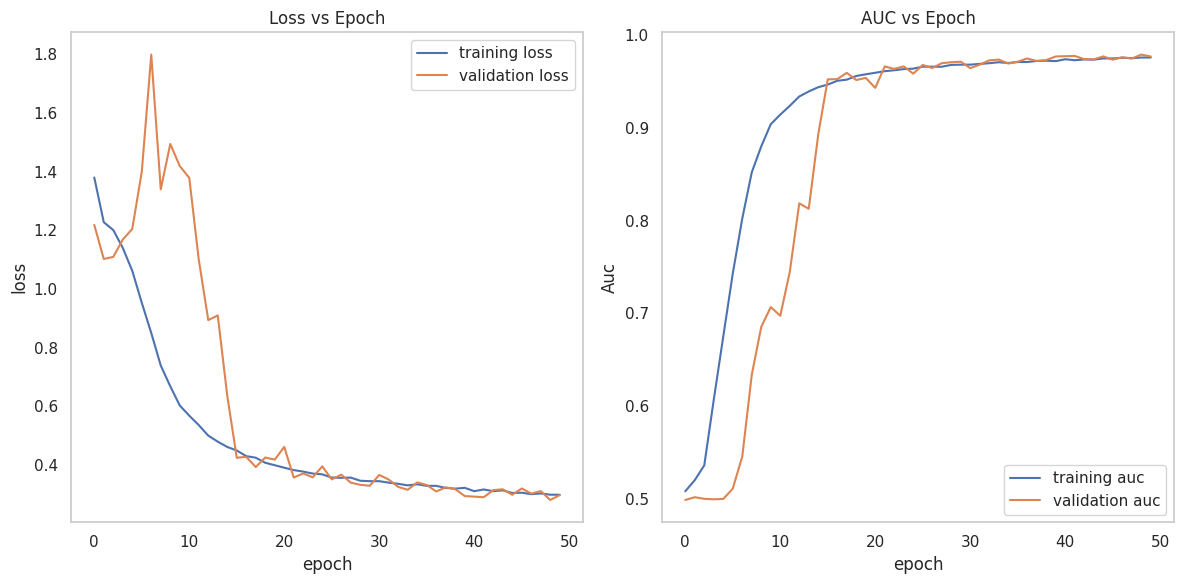

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid()
# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='training auc')
plt.plot(history.history['val_auc'], label='validation auc')
plt.xlabel('epoch')
plt.ylabel('Auc')
plt.title('AUC vs Epoch')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
model.save('resnet50.h5')

In [19]:
from tensorflow import keras
from tensorflow.keras.models import load_model
load_model = keras.models.load_model("resnet50.h5")#compile=False(if you are using another version of tensorflow )

In [20]:
y_true = []
y_pred = []

for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    y_true.extend(y_batch)
    y_pred.extend(load_model.predict(X_batch))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

3/3 [==============================] - 2s 619ms/step


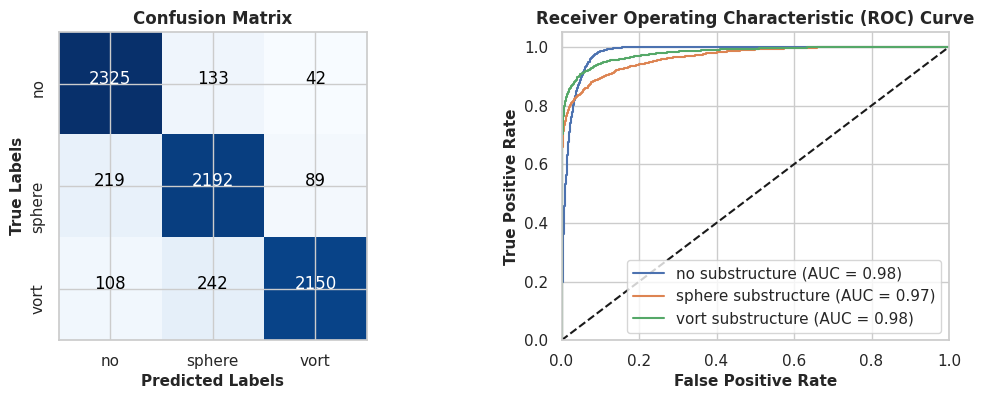

In [21]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 4)) 
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.subplot(121)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=11, fontweight='bold')
plt.ylabel('True Labels', fontsize=11, fontweight='bold')

tick_marks = np.arange(len(val_generator.class_indices))
plt.xticks(tick_marks, val_generator.class_indices)
plt.yticks(tick_marks, val_generator.class_indices, rotation=90)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.subplot(122)
for class_name, i in val_generator.class_indices.items():
    plt.plot(fpr[i], tpr[i], label=f"{class_name} substructure (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.4)
plt.show()